# Diving into BoardGameGeek
> Key insights on board game ratings

- toc: false
- branch: master
- badges: true
- comments: true
- author: Jesse van Elteren
- image: images/bgg.png
- categories: []

![](bgg/bgg.png)

Do you like board games? If you do, you may wonder what other great games are out there. I admit that it's a bit of a guilty pleasure of mine. Many people turn to [BoardGameGeek (BGG)](https://boardgamegeek.com/). This is a great site with many users reviewing games. I used the BGG API to gather information about:
* 410K users reviewing 19M games. E.g. Alice gives Catan an 8
* Information on 22K games, such as game type, complexity, minimum age, game duration etc

Now what is the **best** game? And can we predict the rating a game will receive?
TLDR: There are many ways to sort the games. There are certain factors that influence the ratings:
* **Newer** games receive higher ratings
* **More complex** games receive higher ratings
* **Less active** users give higher ratings

All in all, it's possible to explains ~50% of the variation in ratings.

Let's dive in!

### The users and ratings

In [142]:
# hide
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
from sklearn import linear_model
import warnings
from pandas.errors import DtypeWarning
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import shap
from functools import reduce
import operator

from utils.database import DB
from aocutils.datascience import nan_inspect, save, load

from IPython.display import display_html 

warnings.simplefilter(action='ignore', category=DtypeWarning)
pd.options.display.max_rows = 200
pd.options.display.float_format = "{:,.2f}".format


In [143]:
# hide
def display_dfs_horiz(dfs, titles):
    htmls = []
    for i in range(len(dfs)):
        styler = dfs[i].style.set_table_attributes("style='display:inline'").set_caption(titles[i])
        htmls.append(styler._repr_html_())
    display_html(reduce(operator.add, htmls), raw=True)

def reset_index(df, start=1):
    df.set_index(pd.RangeIndex(start=start, stop=len(df)+1, step=1), inplace=True)
    return df

def types(data, y_col):
    # split columns into sorted numerical and categorical based on correlation with y_col
    corr = data.corr()[y_col]
    corr = corr.sort_values(ascending=False)
    num_x = list(corr.index)[1:]
    cat_x = [col for col in data.columns if data[col].dtype == 'object']
    cat_x.sort(key = lambda x: -correlation_ratio(data[x],data[y_col]))
    return num_x, cat_x

def split(data, y_col):
    # splits dataset into x and y dataset
    data_x = data.drop([y_col], axis=1)
    data_y = data.loc[:,y_col]
    return data_x, data_y

# metric for correlation of categorial features with target. Used for sorting features in displaying
def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

def regr(x, y, s=0.01):
    # make a regression. s is the point size
    regr = linear_model.LinearRegression()
    x = x.values.reshape(-1, 1)
    regr.fit(x, y)
    print(f'r2: {regr.score(x, y):.2f}')
    # plot it as in the example at http://scikit-learn.org/
    plt.scatter(x, y,  color='black',s=s)
    plt.plot(x, regr.predict(x), color='blue', linewidth=3)
    return plt

def reformat_large_tick_values(tick_val, pos):
    """
    Turns large tick values (in the billions, millions and thousands) such as 4500 into 4.5K and also appropriately turns 4000 into 4K (no zero after the decimal).
    """
    if tick_val >= 1000000000:
        val = round(tick_val/1000000000, 1)
        new_tick_format = '{:}B'.format(val)
    elif tick_val >= 1000000:
        val = round(tick_val/1000000, 1)
        new_tick_format = '{:}M'.format(val)
    elif tick_val >= 1000:
        val = round(tick_val/1000, 1)
        new_tick_format = '{:}K'.format(val)
    elif tick_val < 1000:
        new_tick_format = round(tick_val, 1)
    else:
        new_tick_format = tick_val

    # make new_tick_format into a string value
    new_tick_format = str(new_tick_format)
    
    # code below will keep 4.5M as is but change values such as 4.0M to 4M since that zero after the decimal isn't needed
    index_of_decimal = new_tick_format.find(".")
    
    if index_of_decimal != -1:
        value_after_decimal = new_tick_format[index_of_decimal+1]
        if value_after_decimal == "0":
            # remove the 0 after the decimal point since it's not needed
            new_tick_format = new_tick_format[0:index_of_decimal] + new_tick_format[index_of_decimal+2:]
            
    return new_tick_format

In [144]:
# hide
db = DB('bgg2022.db')
df = pd.read_csv('games_detailed_info.csv')
y = 'average'

[('games', 21839), ('reviews', 18964807)]


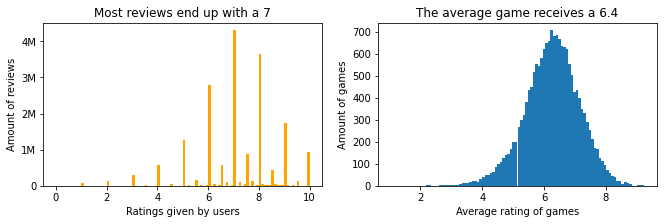

In [177]:
# hide_input
# fig, (ax1, ax2, ax3) = plt.subplots(1,2, figsize=(11,3))
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,3))
ax1.hist(db.df("SELECT rating FROM reviews").astype(float), bins=100, color='orange')
ax1.title.set_text('Most reviews end up with a 7')
ax1.set_xlabel('Ratings given by users')
ax1.set_ylabel('Amount of reviews')
ax1.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
ax2.hist(df[y], bins=100)
ax2.title.set_text('The average game receives a 6.4')
ax2.set_xlabel('Average rating of games')
ax2.set_ylabel('Amount of games');
# ax3.hist(df['bayesaverage'], bins=100);
# ax3.set_xlabel('Average GeekScore of games')

Users give ratings that are often rounded: they give a 7 instead of a 7.23, that's why you see the spikes on the leftmost chart. Around 4 million reviews end up with a 7. 

Looking at the games, we see a nice normal distribution. For the purists: no I've got no intention of testing for normality here😊)

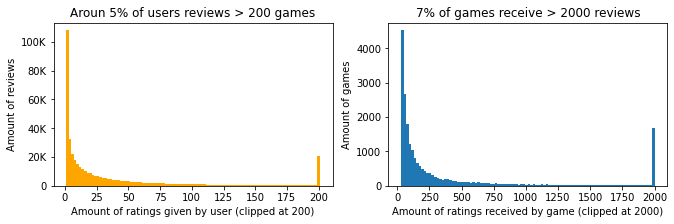

In [176]:
# hide_input
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,3))
users = db.df("SELECT user, COUNT(*) as count, AVG(rating) as average FROM reviews GROUP BY user")
ax1.hist(users['count'].clip(0,201), bins=100, color='orange')
ax1.title.set_text('Aroun 5% of users reviews > 200 games')
ax1.set_xlabel('Amount of ratings given by user (clipped at 200)')
ax1.set_ylabel('Amount of reviews')
ax1.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))


sql = """
    SELECT g.name, g.ID, COUNT(*) as count, AVG(r.rating) as average 
    FROM reviews r
    JOIN games g
    ON g.ID = r.ID
    GROUP BY r.ID
"""
games = db.df(sql)
ax2.hist(games['count'].clip(0,2001), bins=100)
ax2.title.set_text('7% of games receive > 2000 reviews')
ax2.set_xlabel('Amount of ratings received by game (clipped at 2000)')
ax2.set_ylabel('Amount of games');

In [147]:
# hide
(len(users.loc[users['count']==1]) / len(users),
sum(users.loc[users['count']==1]['count']) / sum(users['count']),
len(users.loc[users['count']>=201]) / len(users),
sum(users.loc[users['count']>=201]['count']) / sum(users['count']))
# len(games.loc[games['count']<100]) / len(users)

(0.19440137979148095,
 0.004231627561514336,
 0.04901215069183365,
 0.4274852889354476)

In [148]:
# hide
(len(games.loc[games['count']<100]) / len(games),
sum(games.loc[games['count']<100]['count']) / sum(games['count']),
len(games.loc[games['count']>=2001]) / len(games),
sum(games.loc[games['count']>=2001]['count']) / sum(games['count']))

(0.44443426896835936,
 0.02854898549718961,
 0.07628554420989972,
 0.7255024530436824)

For the pareto fans amount you:
* 19% of **users** only leave 1 review. However, these reviews only account for 0.5% of all reviews
* 5% of users (20k) leave more than 200 reviews. Together they account for 27% of reviews
* 44% of **games** reveive less than 100 reviews. However, these reviews only account of 6% of all reviews.
* 7% of games have 2000 or more reviews, However they make up 39% of all reviews

In [149]:
# hide_input
us = reset_index(users.sort_values('count', ascending=False)[:5])
ga = reset_index(games.sort_values('count', ascending=False)[:5].drop('ID',axis=1))
display_dfs_horiz([us, ga], ['Most active users', 'Most reviewed games'])

,user,count,average
1,oldgoat3769967,6471,6.185752
2,warta,6289,7.230800
3,leffe dubbel,6068,5.937541
4,TomVasel,5672,6.401869
5,Doel,5131,7.496200
,Name,count,average
1,Pandemic,108971,7.594996
2,Carcassonne,108881,7.416162
3,Catan,108195,7.133179
4,7 Wonders,90110,7.733539


Check out the insane number of reviews by oldgoat. And 3 games so close to each other with >100K reviews!

### Rating development over the years

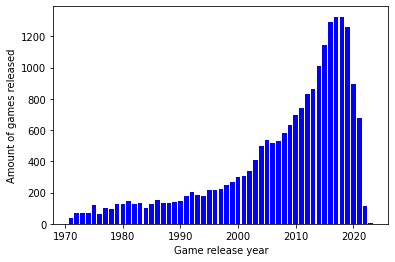

In [150]:
# hide_input
game_amount = df.loc[(df['yearpublished'] > 1970)].groupby('yearpublished')['id'].agg('count')
ax1 = plt.axes()
ax1.bar(game_amount.index, game_amount,  color='blue')
ax1.set_xlabel('Game release year')
ax1.set_ylabel('Amount of games released');

There has been incredible growth in the amount of boardgames being released. It does appears to slow down, although many games are for some reason added a couple of years after they have been released, so the steep drop after 2020 is a bit misleading. I don't know why this is so.

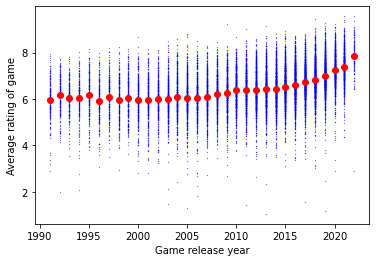

In [151]:
# hide_input
years = df.loc[(df['yearpublished'] > 1990) & (df['yearpublished'] < 2023)]
ax1 = plt.axes()
ax1.scatter(years['yearpublished'], years[y],  color='blue',s=0.05)
ax1.set_xlabel('Game release year')
ax1.set_ylabel('Average rating of game')

years = years.groupby('yearpublished').agg('mean').reset_index()
ax1.scatter(years['yearpublished'], years['average'], color='red');

Are games being rated higher? After 2005 it seems so! Are games nowadays just better or is there a tendency to rate new games higher? Now luckily I've composed this dataset already twice in the past, we can make good use of this:

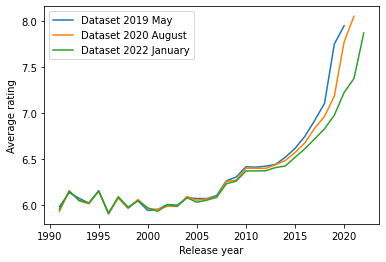

In [152]:
# hide_input
cut = 1990
versions = [('archive/games_detailed_info_2019.csv', 'Dataset 2019 May'),
            ('archive/games_detailed_info_2020.csv', 'Dataset 2020 August'),
            ('games_detailed_info.csv', 'Dataset 2022 January')]
for path, label in versions:
    dfold = pd.read_csv(path)
    df2 = dfold.loc[(dfold['yearpublished'] > cut) & (dfold['yearpublished'] < 2023)]
    yearsold = df2.groupby('yearpublished').agg('mean').reset_index()
    plt.plot(yearsold['yearpublished'], yearsold['average'], label=label)
plt.ylabel('Average rating')
plt.xlabel('Release year')

plt.legend();

My conclusion would be that it's a mix of improved quality and hype:
* Scores have been climbing since 2005. There is a rough consensus that boardgames have improved in quality.
* As you see the 3 snapshots diverge around 2015. This is a 'hype' effect, where the early adopters score a new/upcoming games higher. For any year, the blue line (the ratings from the dataset in 2019) scores highest, after the orange (2020) and lowest in the most recent version of the dataset (2022). Games from 2020 where rated with 7.8 in 2020, but two years later that has dropped to 7.2 and now games from 2022 are rated with 7.8! When games are about 5 years old the 'hype' effect is more or less gone and games reach a stable score (around 2014 there is no difference anymore). 

### Relation between complexity of games and ratings

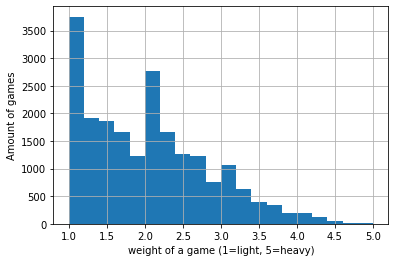

In [153]:
# hide_input
df2 = df.loc[df['averageweight'] > 0]
ax = df2['averageweight'].hist(bins=20)
ax.set_ylabel('Amount of games')
ax.set_xlabel('weight of a game (1=light, 5=heavy)');

BGG has a weight metric, which means how complex a game is. To get a feel what a number means, here some examples:
* Monopoly: 1.3
* Catan: 2.3
* Chess: 3.7

Most of the games have a fairly low weight.


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


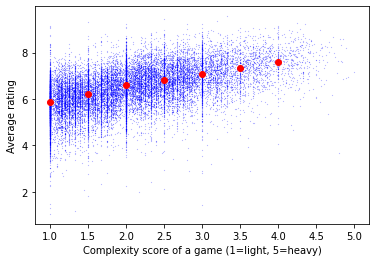

In [154]:
# hide_input
s = 0.01
ax1 = plt.axes()
ax1.scatter(df2['averageweight'], df2[y],  color='blue',s=s)

df2.loc[:,'complexity'] = (df2['averageweight'] // 0.5 * 0.5).copy()
df2 = df2.loc[df2['complexity']<4.5]
complexity = df2.groupby('complexity').agg('mean').reset_index()
ax1.scatter(complexity['complexity'], complexity['average'], color='red')
ax1.set_xlabel('Complexity score of a game (1=light, 5=heavy)');
ax1.set_ylabel('Average rating');

There is a relation between the complexity of the game and the score. More complex games get higher scores, it's almost a 1 point difference between a game with weight 1 and 5! Are heavy games really 'better' than 'light' games?

### Are active users more critical?

In [155]:
# hide
users.sort_values('count', inplace=True)
users['cumsum'] = users['count'].cumsum()
totalreviews = sum(users['count'])
tertile = totalreviews //3
first_tertile = users[users['cumsum'] > tertile].iloc[0]['count']
second_tertile = users[users['cumsum'] > 2*tertile].iloc[0]['count']
first_tertile, second_tertile

(88, 273)

In [156]:
# hide
new = users.loc[users['count']< first_tertile]
middle = users.loc[(users['count']>= first_tertile) & (users['count']<=second_tertile)]
experienced = users.loc[users['count']>second_tertile]
assert len(new) + len(middle) + len(experienced) == len(users)

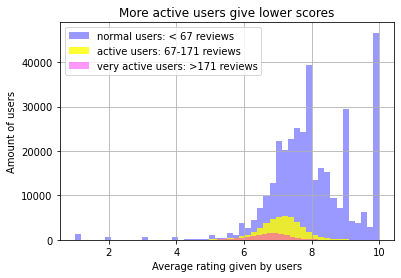

In [157]:
# hide_input
new['average'].hist(bins=50, fc=(0, 0, 1, 0.4), label='normal users: < 67 reviews')
middle['average'].hist(bins=50, fc=(1, 1, 0, 0.8), label='active users: 67-171 reviews')
experienced['average'].hist(bins=50, fc=(1, 0, 1, 0.4), label='very active users: >171 reviews')
plt.title('More active users give lower scores')
plt.xlabel('Average rating given by users')
plt.ylabel('Amount of users')
plt.legend();

In [158]:
# hide
for i in [new, middle, experienced]:
    print(i['average'].mean())
len(experienced)/len(users)
(sum(new['average'] == 10)) / len(users)

8.02995376296331
7.111292974103985
6.74890022410223


0.11120935235068408

Here you see the average rating that different user groups are giving. I've split the population in 3 parts that all account for 33% of the reviews. The very active group gives lower scores (6.9 avg) compared to the active users (7.2 avg) and the normal users (8.1 avg). 
The very active users only make up of 6% the population (note it's a small area), they do give out 33% of the reviews!

Are normal users less critical or just reviewing better quality games?

It's notable that 11% of all users give a 10 on average, which accounts for 0.5% of all reviews. You can make a case for filtering these 
reviews out. Some of the games are rated by many users that have only reviewed one game with a 10. A good example of such a game is [Goblin Grapple](https://boardgamegeek.com/boardgame/245240/goblin-grapple/ratings?rating=10), but there are around 100 games that I find suspect.

### What is the best game?
Now what is the best game? And what reviews to take into account? While doing this project so many ideas came to mind on how a ranking could be defined, e.g.:
* Including reviews given by active users (I took > 10)
* Including games that have received a certain threshold of reviews (I took > 2000)
* Training a model that takes the weight into account, such that the 'complexity bonus' games receive is taken away. I do this by interpreting the residuals of the model as an indication of quality (what the model cannot explain by complexity must be the quality).

What did not really work?
* Account for the release year. This approach I abandoned, since some new games are truly better. The only thing you want to account for is removing the 'hype' effect. I did this by excluding games after 2017 from the analysis.
* Including reviews with a comment, since these people are more strongly opinionated. It did not differ much.
* Training a model that takes the average user rating into account. You could even look at z scores of users.

Let me show you some of the outcomes

In [257]:
# hide
YEAR_CUTOFF = 2018
REVIEW_CUTOFF = 1000
USER_REVIEW_CUTOFF = 10

In [258]:
# hide
df = pd.read_csv('games_detailed_info.csv')
print(len(df))
# clip some values to make plotting easier
df['minplaytime'] = df['minplaytime'].clip(0,500)
df['maxplaytime'] = df['minplaytime'].clip(0,500)
df['maxplayers'] = df['minplaytime'].clip(0,20)
df['yearpublished'] = df['yearpublished'].clip(lower=1970, upper=2030, axis=0)
# I'm filtering out the hype years here
df = df.loc[df['yearpublished'] < YEAR_CUTOFF].reset_index()
df.rename(columns={'primary':'name', 'id':'ID'}, inplace=True)
print(len(df))

21631
17362


In [259]:
#hide
reviews = pd.read_csv('bgg-19m-reviews.csv',index_col=0)
merged_reviews = reviews.merge(users,how='left',on='user',suffixes=('','user'))
merged_reviews['only_one_review'] = (merged_reviews['count'] == 1)*1
merged_reviews.head()

,user,rating,comment,ID,name,count,average,only_one_review
0,Torsten,10.00,NaN,30549,Pandemic,"1,460.00",6.87,0
1,mitnachtKAUBO-I,10.00,Hands down my favorite new game of BGG CON 200...,30549,Pandemic,397.00,6.66,0
2,avlawn,10.00,I tend to either love or easily tire of co-op ...,30549,Pandemic,"1,038.00",6.44,0
3,Mike Mayer,10.00,NaN,30549,Pandemic,729.00,6.81,0
4,Mease19,10.00,This is an amazing co-op game. I play mostly ...,30549,Pandemic,422.00,7.14,0


In [260]:
# hide
condition = merged_reviews['count'] > USER_REVIEW_CUTOFF
merged_games = merged_reviews.loc[condition].groupby(['ID', 'name'])[['rating', 'average', 'only_one_review', 'count']].agg( avg_rating= ('rating', 'mean'),
                                                                                                user_avg_rating= ('average','mean'), 
                                                                                                num_inactive= ('only_one_review','sum'), 
                                                                                                num_reviews=('rating', 'count'), 
                                                                                                user_median_review_count= ('count', 'median'))
merged_games.reset_index(inplace=True)

In [261]:
# hide
df_only_experienced = df.merge(merged_games,how='left',on='ID',suffixes=('', 'review'))
df_only_experienced['proportion_inactive'] = df_only_experienced['num_inactive'] / df_only_experienced['num_reviews']
df_only_experienced.sort_values('avg_rating', ascending=False, inplace=True)
df_only_experienced.set_index(pd.RangeIndex(start=1, stop=len(df_only_experienced)+1, step=1), inplace=True)

# filter out games with < 1000 reviews
print(len(df_only_experienced))
df_only_experienced = df_only_experienced.loc[df_only_experienced['num_reviews']>REVIEW_CUTOFF]
print(len(df_only_experienced))


17362
2362


In [262]:
# hide_input
df_only_experienced[['name', 'avg_rating', 'averageweight', 'yearpublished']][:10]

,name,avg_rating,averageweight,yearpublished
9,Gloomhaven,8.64,3.87,2017
16,Twilight Imperium: Fourth Edition,8.59,4.26,2017
20,Pandemic Legacy: Season 1,8.56,2.83,2015
37,War of the Ring: Second Edition,8.45,4.17,2012
45,Gaia Project,8.43,4.37,2017
53,Star Wars: Rebellion,8.38,3.73,2016
55,Terraforming Mars,8.36,3.24,2016
57,Too Many Bones,8.36,3.84,2017
59,Through the Ages: A New Story of Civilization,8.35,4.41,2015
60,Aeon's End: War Eternal,8.34,2.93,2017


This corresponds more or less to the [top games listed on BGG](https://boardgamegeek.com/browse/boardgame). Note from 'averageweight' that these are all pretty heavy games. Also 2017 appears 5 times.

But I don't have time to play games that are very complex and take many hours! So let's account for the complexity, such that great lighter games will pop up more. I trained a tree based model with a r2 of 0.35. It's only 0.35, but that does mean that 35% of the variation in the rating is explained by the complexity!

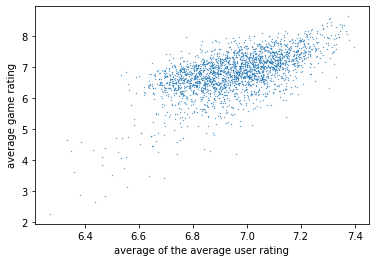

In [263]:
# hide
# Another thing I want to correct for is the effect that if games are rated by users that generally give lower scores, this has an effect on the rating of the game.
# didnt really work out, since the outliers that are rated by grumps get promoted to the top
plt.scatter(df_only_experienced['user_avg_rating'], df_only_experienced['avg_rating'],s=0.1)
plt.xlabel('average of the average user rating')
plt.ylabel('average game rating');

In [264]:
# hide
df_only_experienced['delta_rating_avg_user_rating'] = df_only_experienced['avg_rating'] - df_only_experienced['user_avg_rating']
df_only_experienced.sort_values('delta_rating_avg_user_rating', ascending=False, inplace=True)
df_only_experienced[['name', 'avg_rating', 'delta_rating_avg_user_rating', 'averageweight', 'yearpublished']][:10]

,name,avg_rating,delta_rating_avg_user_rating,averageweight,yearpublished
16,Twilight Imperium: Fourth Edition,8.59,1.28,4.26,2017
9,Gloomhaven,8.64,1.26,3.87,2017
20,Pandemic Legacy: Season 1,8.56,1.26,2.83,2015
271,Shikoku 1889,7.98,1.20,3.91,2004
37,War of the Ring: Second Edition,8.45,1.14,4.17,2012
45,Gaia Project,8.43,1.14,4.37,2017
59,Through the Ages: A New Story of Civilization,8.35,1.07,4.41,2015
154,Triumph & Tragedy: European Balance of Power 1...,8.11,1.05,3.34,2015
65,Kingdom Death: Monster,8.33,1.03,4.26,2015
60,Aeon's End: War Eternal,8.34,1.03,2.93,2017


### Taking complexity out of the equation

In [380]:
# hide
# only keep relevant or minimal features
minimal = ['average', 'averageweight']
df_preprocessed = df_only_experienced[minimal]


In [381]:
# hide
def train(df_preprocessed, y_col, min_data_in_leaf=300):
    train, test = train_test_split(df_preprocessed, test_size=0.2, random_state=112)
    x, y = split(train, y_col)
    x_test, y_test = split(test, y_col)
    print(len(df_preprocessed), len(train), len(test))
    # 
    params = {'num_leaves':6, 'min_data_in_leaf':min_data_in_leaf, 'max_depth':3}
    model = lgb.LGBMRegressor(objective='regression',random_state=112, **params) #
    model = model.fit(x,y)
    print('train score', model.score(x,y))
    print('test score', model.score(x_test,y_test))
    data = {'train_x':x, 'train_y':y, 'test_x':x_test, 'test_y':y_test, 'names':df['name'], 'full_df':df_preprocessed}
    save(model, 'models/lightgbm.pickle')
    save(data, 'models/data.pickle')
    return model

model = train(df_preprocessed, 'average')

2362 1889 473
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
train score 0.34854952793828264
test score 0.31887102027047054


In [382]:
# hide
preds = model.predict(df_preprocessed.drop('average',axis=1))
df2 = df_only_experienced.copy()
df2['preds'] = preds
df2['residual'] = df2['average'] - df2['preds']
df2.sort_values('residual', inplace=True, ascending=False)
df2.set_index(pd.RangeIndex(start=1, stop=len(df2)+1, step=1), inplace=True)

I've taken 1000 reviews as a minimum for the game to be included. That is pretty harsh (only leaves ~15% of the games), but I wanted to be able to recognize some games. This results in the following top 10:

In [383]:
# hide_input
df_excomplex = df2.loc[(df2['usersrated'] > REVIEW_CUTOFF) & (df2['averageweight'] > -1)][['name', 'yearpublished', 'average', 'user_avg_rating', 'preds', 'residual', 'usersrated', 'averageweight']][:10]
df_excomplex.set_index(pd.RangeIndex(start=1, stop=len(df_excomplex)+1, step=1), inplace=True)
df_excomplex

,name,yearpublished,average,user_avg_rating,preds,residual,usersrated,averageweight
1,Crokinole,1970,7.95,7.01,6.23,1.72,13455,1.25
2,Monikers,2015,7.80,7.12,6.23,1.57,4122,1.06
3,Telestrations: 12 Player Party Pack,2011,7.75,7.07,6.23,1.52,2390,1.07
4,Time's Up! Title Recall!,2008,7.71,6.96,6.23,1.48,3266,1.19
5,Pandemic Legacy: Season 1,2015,8.59,7.30,7.17,1.42,45064,2.83
6,KLASK,2014,7.64,7.06,6.23,1.41,6837,1.08
7,Codenames,2015,7.60,7.24,6.23,1.37,74456,1.28
8,Gloomhaven,2017,8.74,7.38,7.45,1.30,47853,3.87
9,Escape the Dark Castle,2017,7.51,7.27,6.23,1.29,2596,1.23
10,Time's Up! Edición Amarilla,2008,7.49,7.11,6.23,1.26,1100,1.11


There are a lot of dexterity and party games in the top, which are of course light games. Pandemic Legacy scores high even while being fairly complex. If we filter out the easiest games we get the following list, of which I find the top 4 to be absolutly great games

In [384]:
# hide_input
df_morecomplex = df2.loc[(df2['usersrated'] > REVIEW_CUTOFF) & (df2['averageweight'] > 1.5)][['name', 'yearpublished', 'average', 'user_avg_rating', 'preds', 'residual', 'usersrated', 'averageweight']][:10]
df_morecomplex.set_index(pd.RangeIndex(start=1, stop=len(df_morecomplex)+1, step=1), inplace=True)
df_morecomplex


,name,yearpublished,average,user_avg_rating,preds,residual,usersrated,averageweight
1,Pandemic Legacy: Season 1,2015,8.59,7.30,7.17,1.42,45064,2.83
2,Gloomhaven,2017,8.74,7.38,7.45,1.30,47853,3.87
3,Star Realms: Colony Wars,2015,7.85,7.20,6.60,1.24,6719,1.90
4,Twilight Imperium: Fourth Edition,2017,8.68,7.31,7.45,1.23,16036,4.26
5,Mythic Battles: Pantheon,2017,8.43,7.35,7.21,1.22,2763,3.03
6,Aeon's End: War Eternal,2017,8.38,7.31,7.17,1.21,4061,2.93
7,Azul,2017,7.80,7.30,6.61,1.19,62860,1.76
8,7 Wonders Duel,2015,8.11,7.34,6.92,1.19,69528,2.22
9,Kingdom Death: Monster,2015,8.61,7.30,7.45,1.16,8068,4.26
10,Patchwork,2014,7.64,7.27,6.51,1.13,52225,1.62


### Wrapping things up with a more complete model

Finally I've also trained a model on multiple variables including what the type of game and the year of publication. This model gets an r2 of almost 0.6, meaning that over ~60% in the variation between the of the rating is determined by these variables. I think this is a pretty good result. Below you see the impact of the most important variables.

In [389]:
# hide
# only keep relevant or minimal features

relevant = ['avg_rating', 'yearpublished', 'minplayers', 'maxplayers',
        'minplaytime',
       'maxplaytime', 'minage', 'boardgamecategory', 'boardgamemechanic', 'boardgamefamily',
       'averageweight', 'proportion_inactive'
       ]
df_preprocessed = df_only_experienced[relevant]

In [459]:
# hide
# hide

df_preprocessed = df_only_experienced[relevant]

chars = "[]'\""
# df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_,]+', '', x))

onehot = ['boardgamecategory', 'boardgamemechanic','boardgamefamily']
onehot = [col for col in onehot if col in df_preprocessed.columns]
for cat in onehot:
    # df[cat] = df[cat].str.replace('[/]+', ",", regex=True)
    df_preprocessed.loc[:,cat] = df_preprocessed[cat].str.replace('[^A-Za-z0-9_,]+', "", regex=True).copy()
    onehotencoded = df_preprocessed[cat].str.get_dummies(sep=',',)
    onehotencoded.fillna(0, inplace=True)
    print(cat, len(onehotencoded.columns))
    df_preprocessed = pd.concat([df_preprocessed.drop(cat, axis=1), onehotencoded], axis=1)
    # some columns like Deduction are duplicated, since they appear in both category and mechanic
    df_preprocessed = df_preprocessed.loc[:,~df_preprocessed.columns.duplicated()].copy()
print(len(df_preprocessed), len(df_preprocessed.dropna(axis=0)))
model = train(df_preprocessed.dropna(axis=0), 'avg_rating', 200)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


boardgamecategory 83
boardgamemechanic 184
boardgamefamily 1818
2362 2362
2362 1889 473
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
train score 0.5381623952956134
test score 0.5197884326606318


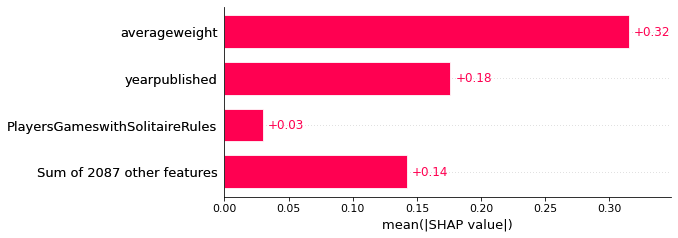

In [460]:
# hide_input
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.TreeExplainer(model)
shap_values = explainer(df_preprocessed.drop('avg_rating', axis=1))
# visualize the first prediction's explanation
# summarize the effects of all the features
shap.plots.bar(shap_values,max_display=4)

As expected the weight/complexity and year of publication have most impact on the rating of a game. Together they roughly impact the score by 0.5 for each game. In addition certain categories also have a small impact on the score. In some more detail:

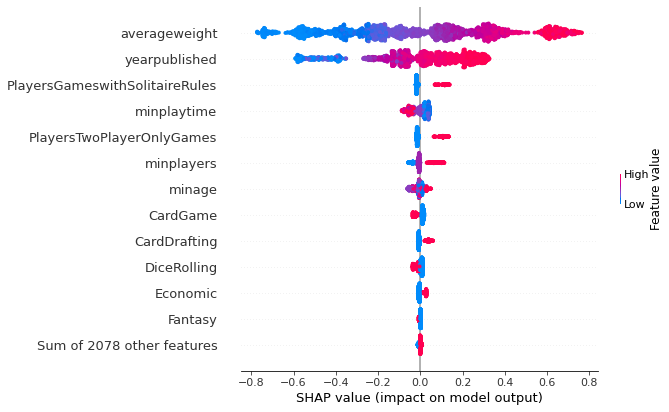

In [461]:
# hide_input
shap.plots.beeswarm(shap_values, 13)

This is what people talk about with 'explainable AI'. The plot can be a bit hard to read. All the dots represent games, and if they are on the right side it means the impact on the model was positive (a higher rating). The color is about the feature value, where blue means low and red high.

What works best is saying it out loud: 'if averageweight is high (red), then the impact is positive and the game will receive higher ratings. For 'AdminBetterDescriptionNeeded' that means that if the game description is lacking, the game will receive lower ratings.

So if you want to receive high ratings with your game, just make sure to make it complex, two players simulated wargame that can be played solitaire with miniatures and online as well. You already get the hype effect for free 😋

That's it, hope you enjoyed this analysis!

> Tip: Some technical info: I've used standard Python data science packages, trained models with [LightGBM](https://lightgbm.readthedocs.io/en/latest/) and the interpretation with [SHAP](https://github.com/slundberg/shap). For the blogging in a notebook I use [Fastpages](https://github.com/fastai/fastpages). All awesome!

> Note: The data is of course owned by [BoardGameGeek](https://boardgamegeek.com/). If you want to play with the data, I've made it into a [Kaggle Dataset](https://www.kaggle.com/jvanelteren/boardgamegeek-reviews)